### Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

| Student Name  | Student ID |
|---------------|------------|
| Haysam Elamin | 8953681    |

---

##### Understanding the Problem
**Objective:**

Build and evaluate deep learning models capable of accurately classifying images of dogs and cats. The goal is to explore both a custom neural network and a transfer learning approach (VGG16) to identify which performs better in terms of accuracy, precision, recall, and generalization. This can be extended to other animal image classification tasks and is foundational for real-world image recognition systems.

**Approach:**

We will work with a subset of the Dogs vs Cats dataset consisting of 5,000 labeled images. The project will include:

**Exploratory Data Analysis (EDA)**

Analyze the dataset through visualizations and statistics to understand the distribution and characteristics of the image data.

**Model Training**

Model 1: Train a custom Convolutional Neural Network (CNN).

Model 2: Fine-tune a VGG16 model pre-trained on ImageNet using transfer learning.

Model Evaluation
Compare model performance using:

**Accuracy**

Confusion matrix

Precision, recall, F1-score

Precision-recall curve

**Error Analysis**
Examine misclassified examples to gain insight into model limitations.

**Conclusion**
Summarize findings and recommend the better model based on performance and generalizability.

In [3]:
# import necessary Dependencies
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image


## 1- Loading the the Dataset
**Download the Dataset**
Go to Kaggle’s Dogs vs Cats Dataset page (you’ll need a Kaggle account).
Download train.zip, which contains 25,000 images, and manually extract 5,000 images (e.g., 2,500 dogs + 2,500 cats).

In [4]:

# === Step 1: Set base path and number of images to use ===
data_dir = "data/train"
NUM_IMAGES = 5000  # You can change this later to use more or fewer images

# === Step 2: List all image filenames in the directory ===
all_filenames = os.listdir(data_dir)

# === Step 3: Filter image files (JPG, JPEG, PNG) ===
image_files = [f for f in all_filenames if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# === Step 4: Shuffle the filenames for randomness ===
import random
random.seed(42)
random.shuffle(image_files)

# === Step 5: Limit the number of images to NUM_IMAGES ===
image_files = image_files[:NUM_IMAGES]

# === Step 6: Create a DataFrame with the selected filenames ===
df = pd.DataFrame(image_files, columns=['filename'])

# === Step 7: Assign labels based on filename ===
df['label'] = df['filename'].apply(lambda x: 1 if 'dog' in x.lower() else 0)

# === Step 8: Reset index and shuffle the DataFrame ===
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# === Step 9: Print basic stats and preview ===
print("Image data loaded and labeled.")
print(f"Total image files used: {len(df)}")
print(df['label'].value_counts())  # Show number of dogs (1) and cats (0)
print(df.head())  # Show a preview of the dataframe

Image data loaded and labeled.
Total image files used: 5000
label
1    2500
0    2500
Name: count, dtype: int64
        filename  label
0   dog.1216.jpg      1
1  cat.10555.jpg      0
2  dog.11401.jpg      1
3  cat.10964.jpg      0
4  cat.11484.jpg      0


### 2- Show Image from Dataset by Changing a Variable

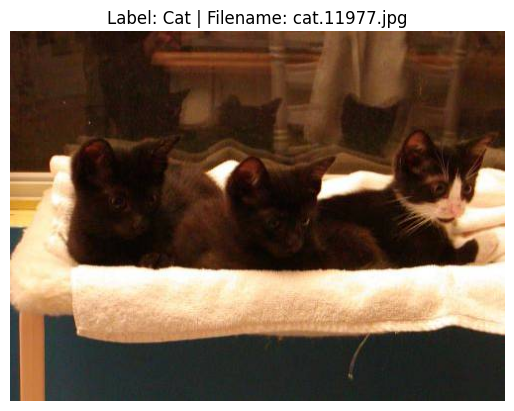

Displayed image #400: cat.11977.jpg (Label: Cat)


In [5]:

# === Variable: Change this to display a different image ===
IMG_INDEX =400  # Change this to any number from 0 to NUM_IMAGES - 1

# === Get the filename and label from the dataframe ===
img_filename = df.loc[IMG_INDEX, 'filename']
img_label = df.loc[IMG_INDEX, 'label']

# === Load the image using PIL ===
img_path = os.path.join(data_dir, img_filename)
img = Image.open(img_path)

# === Display the image with title ===
plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {'Dog' if img_label == 1 else 'Cat'} | Filename: {img_filename}")
plt.show()

print(f"Displayed image #{IMG_INDEX}: {img_filename} (Label: {'Dog' if img_label == 1 else 'Cat'})")

### 3- Image Preprocessing – Convert Images to Numpy Arrays

In [6]:
# Image dimensions
IMG_SIZE = (150, 150)

def load_and_resize_image(filepath):
    img = Image.open(filepath).convert('RGB') # Convert to RGB if not already
    img = img.resize(IMG_SIZE) # Resize to fixed dimensions
    return np.array(img)

# Load and preprocess all images
X = np.array([load_and_resize_image(os.path.join(data_dir, fname)) for fname in df['filename']])
y = df['label'].values

print(f" Processed images shape: {X.shape}")
print(f" Labels shape: {y.shape}")


 Processed images shape: (5000, 150, 150, 3)
 Labels shape: (5000,)


# 4- Show Flattened image X 

In [7]:
print("Shape of X:", X.shape)         # (5000, 150, 150, 3)
print("Data type of X:", X.dtype)     # typically float32 after normalization

# Print pixel values (flattened) for the first image
print("Flattened pixel values of X[0]:")
print(X[0].flatten()[:100])  # show first 100 pixel values to keep it readable


Shape of X: (5000, 150, 150, 3)
Data type of X: uint8
Flattened pixel values of X[0]:
[ 93  98  94  91  96  92  90  95  91  87  92  88  87  93  88  85  93  88
  83  92  87  83  92  87  83  92  87  83  92  88  83  93  90  84  93  90
  83  92  89  85  94  91  86  93  90  87  93  91  88  94  92  85  91  89
  85  91  89  85  89  88  84  87  86  83  86  85  79  83  82  77  79  78
  77  77  76  73  72  70  70  69  64  74  74  67 115 116 106 122 127 112
 122 128 114 122 131 118 119 130 120 120]


## 5- View y array Label

In [8]:
print("Shape of y:", y.shape)         # (5000,)
print("Data type of y:", y.dtype)     # typically int64 or int32

# Print first 20 labels
print("First 20 labels in y:")
print(y[:20])

Shape of y: (5000,)
Data type of y: int64
First 20 labels in y:
[1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0]


# 6- Split into Train and Test Sets



In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize pixel values to [0,1]
X_train = X_train / 255.0
X_val = X_val / 255.0

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Training samples: 4000, Validation samples: 1000


# 7-Build the Vanilla CNN Model 1 

In [10]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary output
])


e:\AI Courses\ML -Framework\Practical Lab 3\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 8- Compile the Model

In [11]:
cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### 9- Train the Model

In [12]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val) # Validation set for monitoring performance during training
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 546ms/step - accuracy: 0.5250 - loss: 0.7079 - val_accuracy: 0.6250 - val_loss: 0.6600
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 580ms/step - accuracy: 0.6442 - loss: 0.6366 - val_accuracy: 0.6840 - val_loss: 0.5987
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 606ms/step - accuracy: 0.6945 - loss: 0.5800 - val_accuracy: 0.6730 - val_loss: 0.5866
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 525ms/step - accuracy: 0.7126 - loss: 0.5516 - val_accuracy: 0.7270 - val_loss: 0.5435
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 561ms/step - accuracy: 0.7412 - loss: 0.5121 - val_accuracy: 0.7280 - val_loss: 0.5197
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 520ms/step - accuracy: 0.7903 - loss: 0.4471 - val_accuracy: 0.7510 - val_loss: 0.4972
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 520ms/step - accuracy: 0.8216 - loss: 0.3831 - val_accuracy: 0.7780 - val_loss: 0.4840
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 482ms/step - accuracy: 0.8723 - loss: 0

## 10- Visualize Training Progress

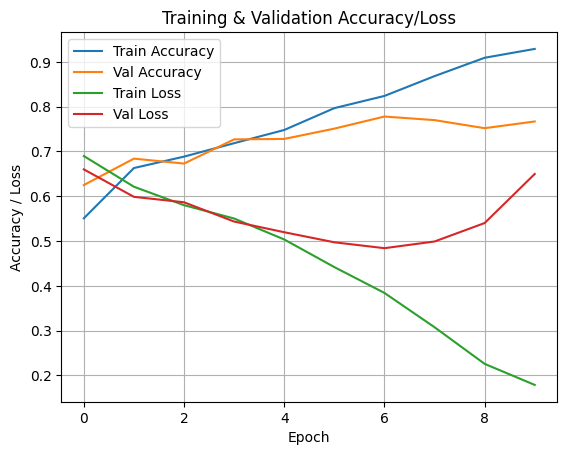

In [13]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy') 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Accuracy/Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()


### 11- Evaluate Model with Confusion Matrix and Classification Report

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation set
y_pred = cnn_model.predict(X_val)
y_pred_labels = (y_pred > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_labels))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_labels, target_names=['Cat', 'Dog']))


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step
Confusion Matrix:
[[432  68]
 [165 335]]

Classification Report:
              precision    recall  f1-score   support

         Cat       0.72      0.86      0.79       500
         Dog       0.83      0.67      0.74       500

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.76      1000
weighted avg       0.78      0.77      0.76      1000



## 12 - Test the Model on a Single Image  
**Objective:**  
Select a specific image from the dataset and display both the actual label and the predicted label using the trained model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


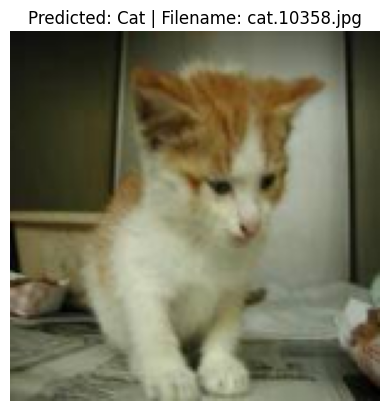

✅ Predicted label for image #123: Cat (Probability: 0.99084)%
Actual label for image #123: Cat


In [15]:
# Select an image by index and predict using the trained model
IMG_INDEX = 123  # Change this to any number from 0 to NUM_IMAGES - 1

# Get the filename and label from the dataframe
img_filename = df.loc[IMG_INDEX, 'filename']
img_path = os.path.join(data_dir, img_filename)

# Load and preprocess the image
img = Image.open(img_path).convert('RGB')
img = img.resize((150, 150))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
pred = cnn_model.predict(img_array)
pred_label = 'Dog' if pred[0][0] > 0.5 else 'Cat'

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_label} | Filename: {img_filename}")
plt.show()

print(f"✅ Predicted label for image #{IMG_INDEX}: {pred_label} (Probability: {1- pred[0][0]:.5f})%")

print(f"Actual label for image #{IMG_INDEX}: {'Dog' if df.loc[IMG_INDEX, 'label'] == 1 else 'Cat'}")

# Model 2 – Transfer Learning with VGG16
**Using VGG16**

### Step 1 – Preprocess Images for VGG16

VGG16 expects images scaled a certain way. We’ll use `preprocess_input()` from Keras to prepare our train and validation sets.


In [16]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# VGG16 expects input in a specific format
X_train_vgg = preprocess_input(X_train.copy() * 255.0)         # Normalize to [0, 255] range
X_val_vgg = preprocess_input(X_val.copy() * 255.0) 


### Step 2 – Load VGG16 Base Model

We load the VGG16 model without its top layers (fully connected layers), and set all layers to non-trainable (frozen) for now.


In [17]:
from tensorflow.keras.applications import VGG16

# Load VGG16 without the top (FC) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers to preserve pre-trained weights
for layer in base_model.layers:
    layer.trainable = False


### Step 3 – Unfreeze Last Layers for Fine-Tuning

We selectively unfreeze the last few layers of VGG16 (e.g., block5) so they can adapt to our dataset. The rest of the network remains frozen.


In [18]:
# Unfreeze only the last 4 layers (you can adjust this as needed)
for layer in base_model.layers[-4:]:
    layer.trainable = True


### Step 4 – Add Custom Layers on Top

We add a global pooling layer and a dense output layer for binary classification (Cat vs Dog).


In [19]:
from tensorflow.keras import layers, models, Input

# Build full model
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

fine_tune_model = models.Model(inputs, outputs)


### Step 5 – Compile the Fine-Tuned Model

We compile the model using a low learning rate (since we’re fine-tuning), binary cross-entropy for binary classification, and accuracy as the evaluation metric.


In [20]:
from tensorflow.keras.optimizers import Adam

fine_tune_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


### Step 6 – Train the Model

We train the fine-tuned model using early stopping to avoid overfitting. Training stops if the validation loss doesn’t improve for 3 epochs.


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_finetune = fine_tune_model.fit(
    X_train_vgg, y_train,
    validation_data=(X_val_vgg, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 754s 6s/step - accuracy: 0.6865 - loss: 2.3550 - val_accuracy: 0.9200 - val_loss: 0.1881
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 804s 6s/step - accuracy: 0.8978 - loss: 0.2875 - val_accuracy: 0.9440 - val_loss: 0.1423


### Step 7 – Visualize Training and Validation Accuracy/Loss

Plot the accuracy and loss curves for both training and validation sets to check the model's learning behavior and detect overfitting.


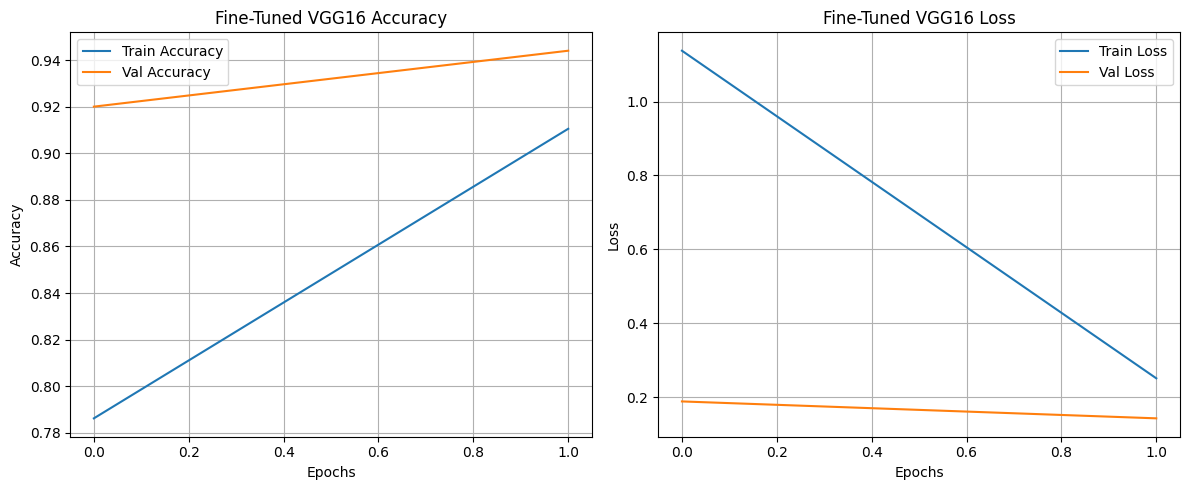

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title('Fine-Tuned VGG16 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuned VGG16 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
